In [18]:
import sys

import torch
import rsatoolbox.data
import rsatoolbox.rdm.calc
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import umap.umap_ as umap
from torchvision.utils import make_grid
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names
from sklearn import manifold
from sklearn.decomposition import PCA

sys.path.append("../src")

import utils  # noqa: E402
import models  # noqa: E402


def sample_images(data_loader, n=5, plot=False):
    """Samples a specified number of images from a data loader."""
    imgs, labels = next(iter(data_loader))

    imgs_o = []
    targets = []
    for value in range(10):
        imgs_o.append(imgs[np.where(labels == value)][0:n])
        targets.append([value] * n)

    imgs = torch.cat(imgs_o, dim=0)
    targets = torch.tensor(targets).flatten()

    if plot:
        plt.imshow(
            torch.moveaxis(
                make_grid(imgs, nrow=n, padding=0, normalize=False, pad_value=0), 0, -1
            )
        )
        plt.title("Sampled Test Images (5 of each class)")
        plt.axis("off")
        plt.show()

    return imgs, targets


def extract_features(model, imgs, return_layers):
    """Extracts features from specified layers of the model."""
    if return_layers == "all":
        # Automatically get the names of all layers in the model
        return_layers, _ = get_graph_node_names(model)

    # Create the feature extractor
    feature_extractor = create_feature_extractor(model, return_nodes=return_layers)
    model_features = feature_extractor(imgs)

    # Add input images (not a layer, but useful for RDM comparison)
    model_features = {"input": imgs, **model_features}
    return model_features

/Users/jsn/dev/backpropaganda/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Config
n_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
bp_model = models.LeNet5(n_classes=10, latent_dim=84, act_fn="relu")
bp_model.load_state_dict(torch.load("../results/backprop-model.pth"))
bp_model.eval().to(device)

ff_model = models.FFLeNet5(n_classes=10, latent_dim=84)
ff_model.load_state_dict(torch.load("../results/ff-model.pth"))
ff_model.eval().to(device)

pc_model = models.PCLeNet5(n_classes=10, latent_dim=84)
pc_model.load_state_dict(torch.load("../results/pc-model.pth"))
pc_model.eval().to(device)

# Load data
batch_size = 500  # Does not matter here
_, _, test_loader = utils.load_mnist_data(batch_size)
class_names = [str(i) for i in range(n_classes)]

In [20]:
train_nodes, val_nodes = get_graph_node_names(bp_model)
print(f"LeNet5: {train_nodes=}")
train_nodes, val_nodes = get_graph_node_names(ff_model)
print(f"FFLeNet5: {train_nodes=}")
train_nodes, val_nodes = get_graph_node_names(pc_model)
print(f"PCLeNet5: {train_nodes=}")

LeNet5: train_nodes=['x', 'conv1', 'relu', 'pool1', 'conv2', 'relu_1', 'pool2', 'conv3', 'relu_2', 'flatten', 'fc1', 'relu_3', 'fc2']
FFLeNet5: train_nodes=['x', 'conv1.conv1_weight', 'conv1.conv1_bias', 'conv1.conv2d', 'conv1.relu', 'pool1', 'conv2.conv2_weight', 'conv2.conv2_bias', 'conv2.conv2d', 'conv2.relu', 'pool2', 'conv3.conv3_weight', 'conv3.conv3_bias', 'conv3.conv2d', 'conv3.relu', 'flatten', 'fc1.fc1_weight', 'fc1.fc1_bias', 'fc1.linear', 'fc1.relu', 'fc2.fc2_weight', 'fc2.fc2_bias', 'fc2.linear']
PCLeNet5: train_nodes=['input', '0.0', '0.1', '0.2', '1.0', '1.1', '1.2', '2.0', '2.1', '2.2', '3.0', '3.1', '4.0']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].


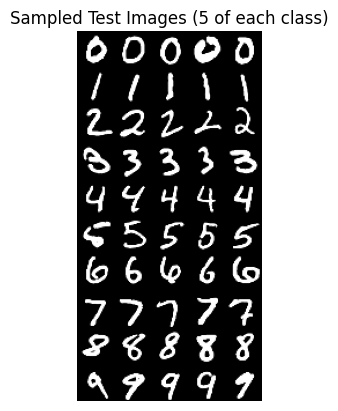

Extracting features (backprop)
Extracting features (forward-forward)
Extracting features (predictive coding)


In [21]:
import train.ff

imgs, targets = sample_images(test_loader, n=5, plot=True)
imgs_overlay = train.ff.overlay_label(imgs, targets, n_classes, is_positive=True)

# NOTE: analyze after activation (captures full non-linear representation)
print("Extracting features (backprop)")
layer_names = ["pool1", "pool2", "relu_2", "relu_3", "fc2"]
bp_features = extract_features(bp_model, imgs.to(device), return_layers=layer_names)

print("Extracting features (forward-forward)")
layer_names = ["pool1", "pool2", "conv3.relu", "fc1.relu", "fc2.linear"]
ff_features = extract_features(
    ff_model, imgs_overlay.to(device), return_layers=layer_names
)

print("Extracting features (predictive coding)")
layer_names = ["0.2", "1.2", "2.2", "3.1", "4.0"]
pc_features = extract_features(pc_model, imgs.to(device), return_layers=layer_names)

# Rename to match the backpropagation model
ff_features = {
    "input": ff_features["input"],
    "pool1": ff_features["pool1"],
    "pool2": ff_features["pool2"],
    "relu_2": ff_features["conv3.relu"],
    "relu_3": ff_features["fc1.relu"],
    "fc2": ff_features["fc2.linear"],
}

pc_features = {
    "input": pc_features["input"],
    "pool1": pc_features["0.2"],
    "pool2": pc_features["1.2"],
    "relu_2": pc_features["2.2"],
    "relu_3": pc_features["3.1"],
    "fc2": pc_features["4.0"],
}

## RDMs

In [22]:
def calc_rdms(model_features, method="correlation"):
    """Calculates representational dissimilarity matrices (RDMs) for model features.

    Args:
        model_features: A dictionary where keys are layer names and values are features of the layers.
        method: The method to calculate RDMs, e.g., 'correlation'. Default is 'correlation'.

    Outputs:
        rdms: RDMs object containing dissimilarity matrices.
        rdms_dict: A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]

        feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = rsatoolbox.data.Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = rsatoolbox.rdm.calc.calc_rdm(ds_list, method=method)
    rdms_dict = {
        list(model_features.keys())[i]: rdms.get_matrices()[i]
        for i in range(len(model_features))
    }

    return rdms, rdms_dict


def plot_maps(model_features, model_name):
    """Plots representational dissimilarity matrices (RDMs) across different layers."""
    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(f"RDMs across layers – {model_name}")
    gs = fig.add_gridspec(1, len(model_features))
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    for l, layer in enumerate(model_features.keys()):
        map_ = np.squeeze(model_features[layer])

        if len(map_.shape) < 2:
            side_len = int(np.sqrt(map_.shape[0]))
            if side_len * side_len == map_.shape[0]:
                map_ = map_.reshape((side_len, side_len))

        if np.max(map_) > 0:
            map_ = map_ / np.max(map_)

        ax = plt.subplot(gs[0, l])
        ax_ = ax.imshow(map_, cmap="magma_r")
        ax.set_title(f"Layer: {layer}")
        ax.set_xlabel("Input Index")
        if l == 0:
            ax.set_ylabel("Input Index")

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(ax_, cax=cbar_ax)
    cbar.set_label("Dissimilarity", rotation=270, labelpad=15)

    plt.show()

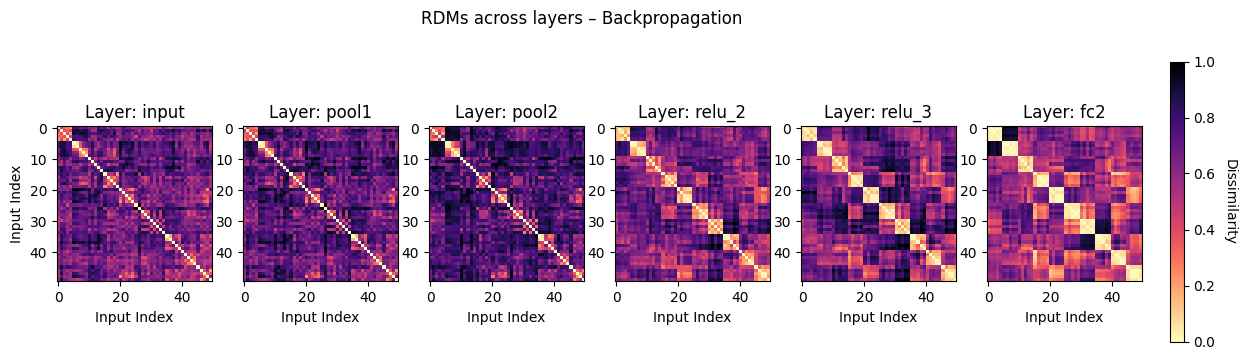

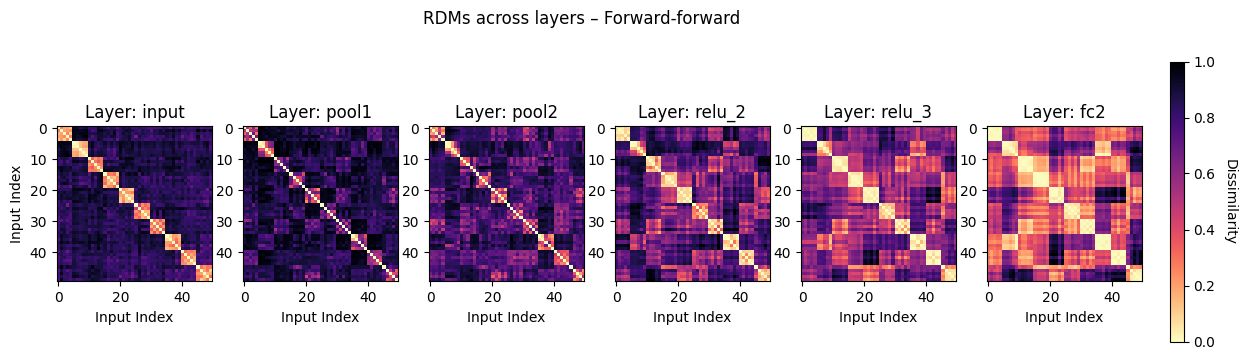

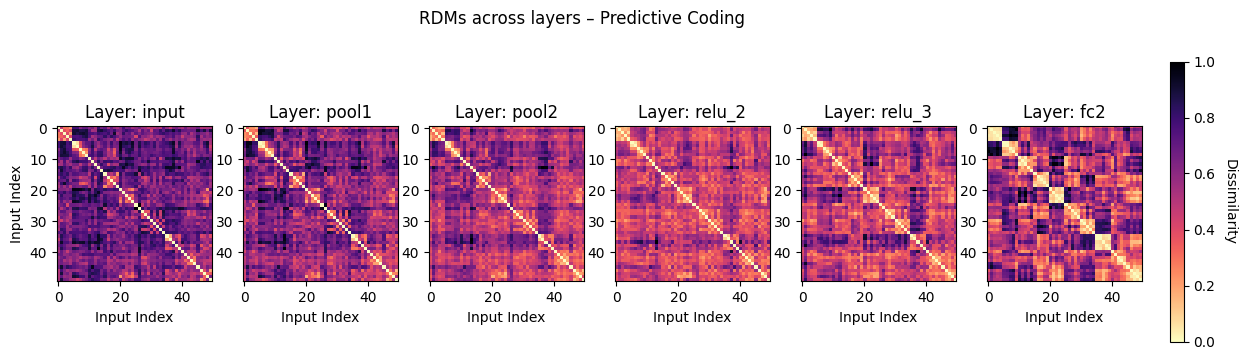

In [23]:
rdms_bp, rdms_dict_bp = calc_rdms(bp_features)
plot_maps(rdms_dict_bp, "Backpropagation")

rdms_ff, rdms_dict_ff = calc_rdms(ff_features)
plot_maps(rdms_dict_ff, "Forward-forward")

rdms_pc, rdms_dict_pc = calc_rdms(pc_features)
plot_maps(rdms_dict_pc, "Predictive Coding")

## Dimensionality Reduction

In [ ]:
def plot_dim_reduction(model_features, labels, transformer_funcs, algorithm):
    """Plots the dimensionality reduction results for model features."""
    transformers = []
    for t in transformer_funcs:
        if t == "PCA":
            transformers.append(PCA(n_components=2, random_state=42))
        elif t == "MDS":
            transformers.append(
                manifold.MDS(n_components=2, normalized_stress="auto", random_state=42)
            )
        elif t == "t-SNE":
            transformers.append(
                manifold.TSNE(n_components=2, perplexity=40, verbose=0, random_state=42)
            )
        elif t == "UMAP":
            transformers.append(umap.UMAP(n_components=2, random_state=42))

    n_rows = len(transformers)
    n_cols = len(model_features)
    fig = plt.figure(figsize=(2.25 * n_cols, 2.25 * n_rows))
    gs = fig.add_gridspec(n_rows, n_cols)
    fig.subplots_adjust(wspace=0.25, hspace=0.25)

    return_layers = list(model_features.keys())

    num_classes = len(np.unique(labels))
    cmap = plt.get_cmap("viridis_r", num_classes)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5, num_classes), cmap.N)

    for i, transformer in enumerate(transformers):
        for j, layer in enumerate(return_layers):
            feats = model_features[layer].detach().cpu().flatten(1)
            feats_transformed = transformer.fit_transform(feats)

            ax = fig.add_subplot(gs[i, j])
            ax.axis("off")

            x_min, x_max = feats_transformed[:, 0].min(), feats_transformed[:, 0].max()
            y_min, y_max = feats_transformed[:, 1].min(), feats_transformed[:, 1].max()
            x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
            max_range = max(x_max - x_min, y_max - y_min) * 0.65
            ax.set_xlim(x_center - max_range, x_center + max_range)
            ax.set_ylim(y_center - max_range, y_center + max_range)

            scatter = ax.scatter(
                feats_transformed[:, 0],
                feats_transformed[:, 1],
                c=labels,
                cmap=cmap,
                norm=norm,
                s=25,
                edgecolors="white",
                linewidths=0.5,
                alpha=0.9,
            )

            if i == 0:
                ax.set_title(layer, fontsize=14)
            if j == 0:
                ax.annotate(
                    transformer_funcs[i],
                    xy=(-0.25, 0.5),
                    xycoords="axes fraction",
                    ha="right",
                    va="center",
                    fontsize=14,
                    rotation=90,
                )

    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
    cbar = fig.colorbar(scatter, cax=cbar_ax, ticks=np.arange(num_classes))
    cbar.ax.set_ylabel("Class", rotation=270, labelpad=15)

    fig.suptitle(
        f"Dimensionality Reduction Across Layers – {algorithm}",
        fontsize=16,
        weight="bold",
        x=0.53,
        y=1.0,
    )
    plt.show()


def plot_dim_reduction_multiple_algorithms(
    all_model_features: dict, labels, transformer_name: str
):
    # Select transformer
    if transformer_name == "PCA":
        transformer = PCA(n_components=2, random_state=42)
    elif transformer_name == "MDS":
        transformer = manifold.MDS(
            n_components=2, normalized_stress="auto", random_state=42
        )
    elif transformer_name == "t-SNE":
        transformer = manifold.TSNE(
            n_components=2, perplexity=40, verbose=0, random_state=42
        )
    elif transformer_name == "UMAP":
        transformer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError(f"Unknown transformer: {transformer_name}")

    algo_names = list(all_model_features.keys())
    layers = list(next(iter(all_model_features.values())).keys())

    n_rows = len(algo_names)
    n_cols = len(layers)
    fig = plt.figure(figsize=(2.25 * n_cols, 2.25 * n_rows))
    gs = fig.add_gridspec(n_rows, n_cols)
    fig.subplots_adjust(wspace=0.25, hspace=0.25)

    num_classes = len(np.unique(labels))
    cmap = plt.get_cmap("viridis_r", num_classes)
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5, num_classes), cmap.N)

    for i, algo in enumerate(algo_names):
        for j, layer in enumerate(layers):
            feats = all_model_features[algo][layer].detach().cpu().flatten(1)
            feats_transformed = transformer.fit_transform(feats)

            ax = fig.add_subplot(gs[i, j])
            ax.axis("off")

            # Centered axis limits
            x_min, x_max = feats_transformed[:, 0].min(), feats_transformed[:, 0].max()
            y_min, y_max = feats_transformed[:, 1].min(), feats_transformed[:, 1].max()
            x_center, y_center = (x_min + x_max) / 2, (y_min + y_max) / 2
            max_range = max(x_max - x_min, y_max - y_min) * 0.65
            ax.set_xlim(x_center - max_range, x_center + max_range)
            ax.set_ylim(y_center - max_range, y_center + max_range)

            scatter = ax.scatter(
                feats_transformed[:, 0],
                feats_transformed[:, 1],
                c=labels,
                cmap=cmap,
                norm=norm,
                s=25,
                edgecolors="white",
                linewidths=0.5,
                alpha=0.9,
            )

            if i == 0:
                ax.set_title(layer, fontsize=14)
            if j == 0:
                ax.annotate(
                    algo,
                    xy=(-0.25, 0.5),
                    xycoords="axes fraction",
                    ha="right",
                    va="center",
                    fontsize=14,
                    rotation=90,
                )

    # Colorbar
    cbar_ax = fig.add_axes([0.92, 0.2, 0.015, 0.6])
    cbar = fig.colorbar(scatter, cax=cbar_ax, ticks=np.arange(num_classes))
    cbar.ax.set_ylabel("Class", rotation=270, labelpad=15)

    # Auto-centering suptitle
    title_x = (fig.subplotpars.left + fig.subplotpars.right) / 2
    fig.suptitle(
        f"Dimensionality Reduction Across Layers",
        fontsize=16,
        weight="bold",
        x=title_x,
        y=1.0,
    )

    plt.show()

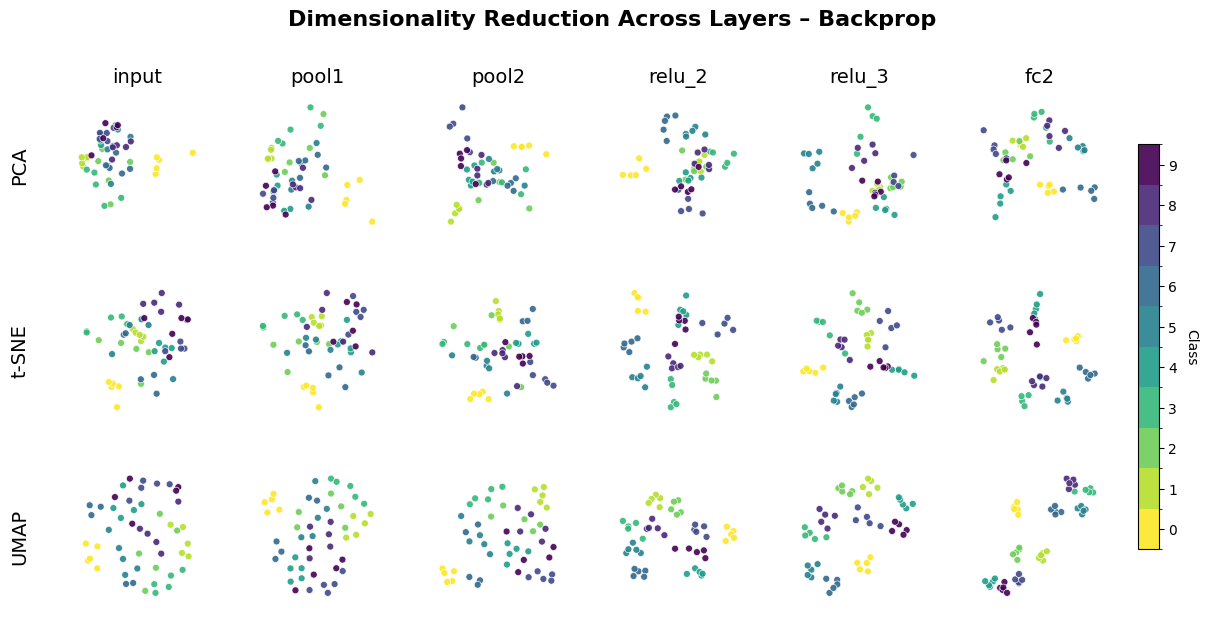

In [67]:
plot_dim_reduction(
    bp_features,
    targets,
    transformer_funcs=["PCA", "t-SNE", "UMAP"],
    algorithm="Backprop",
)

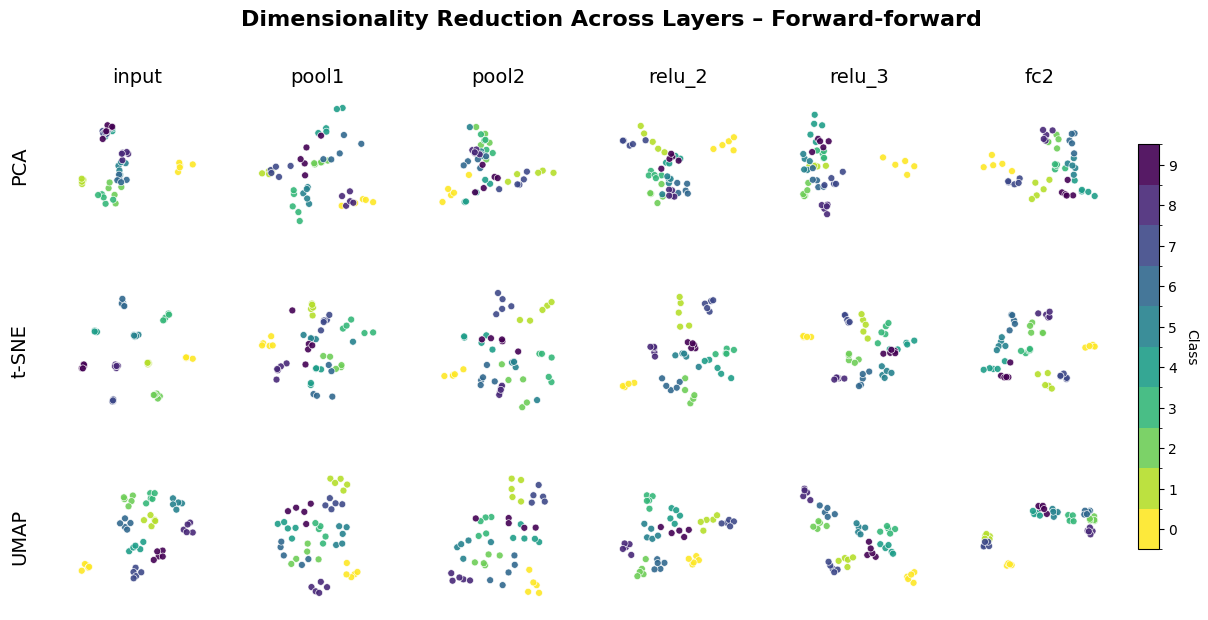

In [68]:
plot_dim_reduction(
    ff_features,
    targets,
    transformer_funcs=["PCA", "t-SNE", "UMAP"],
    algorithm="Forward-forward",
)

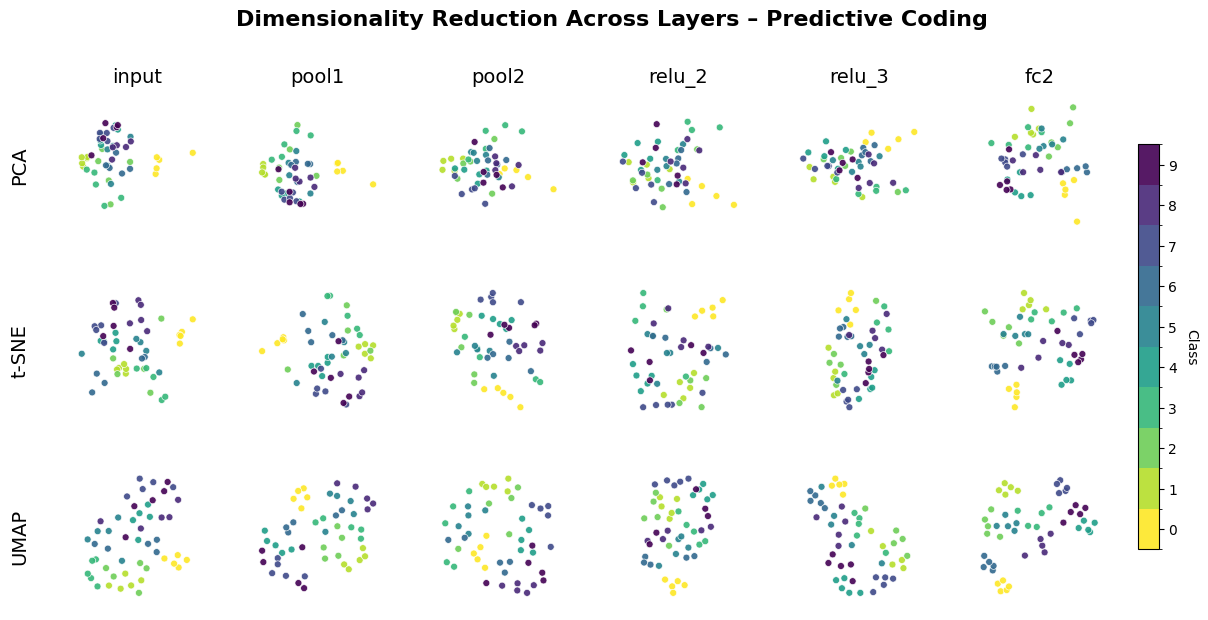

In [69]:
plot_dim_reduction(
    pc_features,
    targets,
    transformer_funcs=["PCA", "t-SNE", "UMAP"],
    algorithm="Predictive Coding",
)

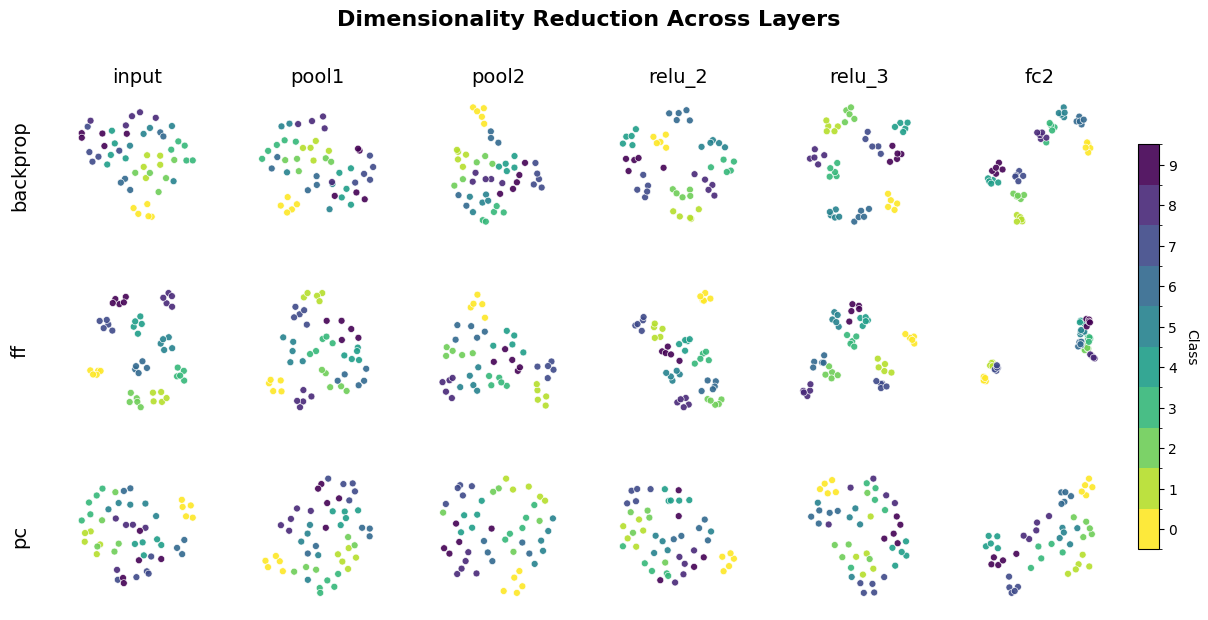

In [75]:
plot_dim_reduction_multiple_algorithms(
    {"backprop": bp_features, "ff": ff_features, "pc": pc_features},
    targets,
    transformer_name="UMAP",
)

## Representational Path

In [208]:
import torch.nn.functional as F


def rep_path(
    model_features,
    model_colors,
    labels=None,
    rdm_calc_method="euclidean",
    rdm_comp_method="cosine",
):
    """Represents paths of model features in a reduced-dimensional space.

    Inputs:
    - model_features: Dictionary containing model features for each model.
    - model_colors: Dictionary mapping model names to colors for visualization.
    - labels: Array of labels corresponding to the model features.
    - rdm_calc_method: Method for calculating RDMS ('euclidean' or 'correlation').
    - rdm_comp_method: Method for comparing RDMS ('cosine' or 'corr').
    """
    path_len = []
    path_colors = []
    rdms_list = []
    ax_ticks = []
    tick_colors = []
    model_names = list(model_features.keys())

    for m in range(len(model_names)):
        model_name = model_names[m]
        features = model_features[model_name]
        path_colors.append(model_colors[model_name])
        path_len.append(len(features))
        ax_ticks.append(list(features.keys()))
        tick_colors.append([model_colors[model_name]] * len(features))
        rdms, _ = calc_rdms(features, method=rdm_calc_method)
        rdms_list.append(rdms)

    path_len = np.insert(np.cumsum(path_len), 0, 0)
    input_idxs = list(path_len[:-1])

    if labels is not None:
        rdms, _ = calc_rdms(
            {"labels": F.one_hot(labels).float().to(device)}, method=rdm_calc_method
        )
        rdms_list.append(rdms)
        ax_ticks.append(["labels"])
        tick_colors.append(["m"])
        idx_labels = -1

    rdms = rsatoolbox.rdm.concat(rdms_list)

    # Flatten the list
    ax_ticks = [l for model_layers in ax_ticks for l in model_layers]
    tick_colors = [l for model_layers in tick_colors for l in model_layers]
    tick_colors = [
        "k" if tick == "input" else color for tick, color in zip(ax_ticks, tick_colors)
    ]

    rdms_comp = rsatoolbox.rdm.compare(rdms, rdms, method=rdm_comp_method)
    if rdm_comp_method == "cosine":
        rdms_comp = np.clip(rdms_comp, -1.0, 1.0)
        rdms_comp = np.arccos(rdms_comp)
    rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)

    # Symmetrize
    rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

    # Reduce dim to 2
    transformer = manifold.MDS(
        n_components=2,
        max_iter=1000,
        n_init=10,
        normalized_stress="auto",
        dissimilarity="precomputed",
        random_state=42,
    )
    dims = transformer.fit_transform(rdms_comp)

    # Remove duplicates of the input layer from multiple models
    # remove_duplicates = np.where(np.array(ax_ticks) == 'input')[0][1:]
    # for index in remove_duplicates:
    #     del ax_ticks[index]
    #     del tick_colors[index]
    #     rdms_comp = np.delete(np.delete(rdms_comp, index, axis=0), index, axis=1)

    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2])
    fig.subplots_adjust(wspace=0.2, hspace=0.2)

    # Plot dissimilarity matrix
    ax = plt.subplot(gs[0, 0])
    ax_ = ax.imshow(rdms_comp, cmap="viridis_r")
    fig.subplots_adjust(left=0.2)
    cbar_ax = fig.add_axes([-0.01, 0.2, 0.01, 0.5])
    fig.colorbar(ax_, cax=cbar_ax, location="left")
    ax.set_title("Dissimilarity Between Layer RDMs", fontdict={"fontsize": 14}, y=1.02)
    ax.set_xticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7, rotation=90)
    ax.set_yticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7)
    [t.set_color(i) for (i, t) in zip(tick_colors, ax.xaxis.get_ticklabels())]
    [t.set_color(i) for (i, t) in zip(tick_colors, ax.yaxis.get_ticklabels())]

    # Colorbar
    ax = plt.subplot(gs[0, 1])
    amin, amax = dims.min(), dims.max()
    amin, amax = (amin + amax) / 2 - (amax - amin) * 5 / 8, (amin + amax) / 2 + (
        amax - amin
    ) * 5 / 8

    # Plot geometry paths
    for i in range(len(rdms_list) - 1):
        path_indices = np.arange(path_len[i], path_len[i + 1])
        ax.plot(
            dims[path_indices, 0],
            dims[path_indices, 1],
            color=path_colors[i],
            marker=".",
            label=model_names[i],
        )
        ax.set_title(
            "Representational Geometry Path", fontdict={"fontsize": 14}, y=1.02
        )
        ax.set_xlim([amin, amax])
        ax.set_ylim([amin, amax])

    for idx in input_idxs:
        if idx == 0:
            ax.plot(
                dims[idx, 0],
                dims[idx, 1],
                color="k",
                marker="s",
                markersize=6,
                label="input",
                linestyle="None",
            )
        ax.plot(dims[idx, 0], dims[idx, 1], color="k", marker="s", markersize=6)

    if labels is not None:
        ax.plot(
            dims[idx_labels, 0],
            dims[idx_labels, 1],
            color="m",
            marker="*",
            markersize=10,
            label="label",
            linestyle="None",
        )

    ax.legend(fontsize=8, loc="best", frameon=False)
    fig.suptitle(
        "Representational Geometry Comparison", fontsize=15, weight="bold", y=1.03
    )
    fig.tight_layout()

In [ ]:
import seaborn as sns

imgs, targets = imgs.to(device), targets.to(device)

features_without_labels = {
    "backprop": bp_features,
    "ff": ff_features,
    "pc": pc_features,
}

colors = sns.color_palette("deep", len(features_without_labels))
colors = {k: color for k, color in zip(features_without_labels.keys(), colors)}

/var/folders/2t/jw0zh_ts0q19czmdc_ssfz2h0000gn/T/ipykernel_37582/2788221075.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


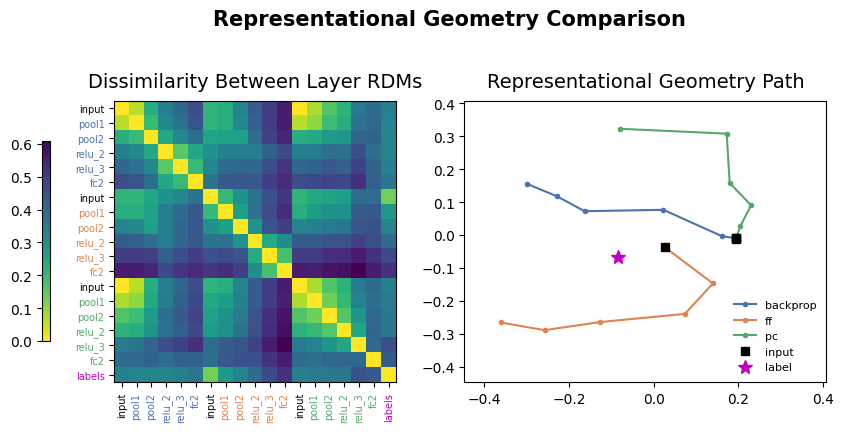

In [209]:
rep_path(features_without_labels, colors, targets)

/var/folders/2t/jw0zh_ts0q19czmdc_ssfz2h0000gn/T/ipykernel_37582/3301623030.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


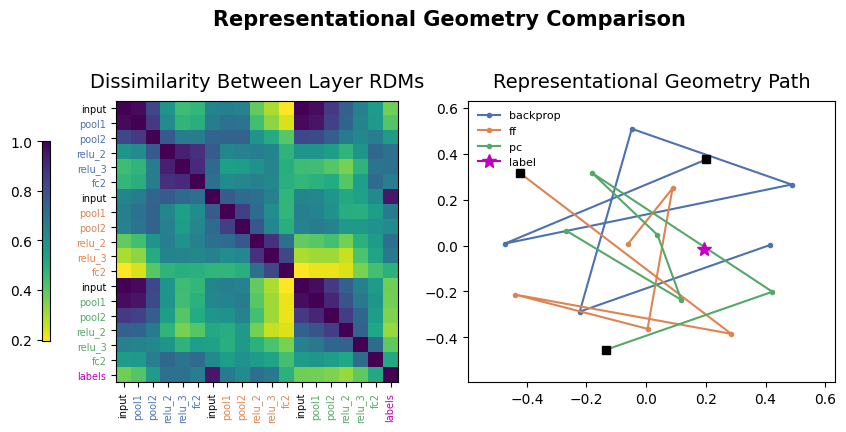

In [203]:
rep_path(
    features_without_labels,
    colors,
    targets,
    rdm_calc_method="correlation",
    rdm_comp_method="corr",
)

## Bootstrap